In [1]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install seaborn
import numpy as np
import pandas
import seaborn as sns
import warnings
from ipywidgets import FloatProgress
from IPython.display import display, Markdown, Latex

In [2]:
debug_rounds = False
debug_matches = False

In [3]:
def d20():
    return np.random.randint(1,21)

def do_rounds_and_update(a,b,rounds,df):
    wins = do_match(a,b,rounds)
    a_wins = wins[0]
    b_wins = wins[1]
    a_id = a[0]
    b_id = b[0]
    df.at[a_id,'total_wins'] = df.at[a_id,'total_wins'] + a_wins
    df.at[b_id,'total_wins'] = df.at[b_id,'total_wins'] + b_wins
    if a_wins > b_wins:
        df.at[a_id,'pair_wins'] = df.at[a_id,'pair_wins'] + 1
    else:
        df.at[b_id,'pair_wins'] = df.at[b_id,'pair_wins'] + 1
    return df

def do_match(a,b,rounds):
    a_wins = 0
    b_wins = 0
    for _ in np.arange(rounds):
        wins = do_round(a,b)
        a_wins = a_wins + wins[0]
        b_wins = b_wins + wins[1]
    if debug_matches:
        print ("After %d rounds %s won %d times and %s won %d times" % (rounds,a.name,a_wins,b.name,b_wins))
    return [a_wins,b_wins]

def do_round( a, b ):
    a_init = d20() + a.init
    if debug_rounds:
        print("%s rolled %d init" % (a.name,a_init))
    b_init = d20() + b.init
    if debug_rounds:
        print("%s rolled %d init" % (b.name,b_init))
    if (a_init >= b_init):
        first = a.copy()
        second = b.copy()
        in_order = True
    else:
        first = b.copy()
        second = a.copy()
        in_order = False
    round = 0
    while (first.hp > 0 and second.hp > 0):
        if debug_rounds:
            print("    Round %d: %s hp is %d and %s hp is %d" % (round+1, first.name,first.hp,second.name,second.hp))
        round = round + 1
        first,second = do_attack(first,second)
        if (second.hp <= 0):
            if debug_rounds:
                print("%s is dead" % second.name)
            if in_order:
                return [1,0] #a went first and won
            else:
                return [0,1] #b went first and won
        else:
            second,first = do_attack(second,first)
            if (first.hp <= 0):
                if debug_rounds:
                    print("%s is dead" % first.name)
                if in_order:
                    return [0,1] #b went second and won
                else:
                    return [1,0] #a went second and won
    """Something went wrong here, nobody wins"""
    return [0,0]
    
def do_attack( attacker, target ):
    if debug_rounds:
        print ("        %s makes %d attacks against %s" % (attacker.name, attacker.att_num, target.name))
    for _ in np.arange(attacker.att_num):
        attack = d20() + attacker.hit_mod
        if (attack >= target.ac):
            target.hp = target.hp - attacker.dam_avg
            if debug_rounds:
                print("            %s hits %s for %d damage" % (attacker.name, target.name, attacker.dam_avg ))
        else:
            if debug_rounds:
                print("            %s misses %s" % (attacker.name, target.name))
    return [attacker, target]

def run_matches(creatures,rounds,name="creatures"):
    rows = creatures.shape[0]
    creatures['pair_wins'] = np.zeros(rows)
    creatures['total_wins'] = np.zeros(rows)

    matches = ((rows-1)**2 + rows - 1)/2 #nth triangular number for n-1

    f = FloatProgress(min=0, max=matches, description="Contest: ")
    display(f)

    print("Performing %d matches of %d rounds each" % (matches,rounds))
    for i in np.arange(rows):
        a = creatures.take([i]).to_records()[0]
        for j in np.arange(i+1,rows):
            b = creatures.take([j]).to_records()[0]
            creatures = do_rounds_and_update(a,b,rounds,creatures)
            f.value = f.value + 1
    
    filename = "%s_%02d.csv" % (name,rounds)
    creatures.to_csv(filename)

def gen_init(amount):
    """Generate initiative modifiers in range -5,5 with normal distribution"""
    s = np.round(np.random.normal(0, 1.66, amount),2)
    p = pandas.DataFrame(data=s)
    p = p[p[0].between(-5, 5, inclusive=True)]
    return p

def gen_ac(amount):
    return np.random.randint(13,20,amount)

def gen_hp(amount):
    return np.random.randint(10,810,amount)

def gen_att_num(amount):
    return np.random.randint(1,6,amount)

def gen_hit_mod(amount):
    return np.random.randint(3,15,amount)

def gen_dam_avg(amount):
    return np.random.randint(2,62,amount)

def create_randoms(size):
    """name,cr,ac,hp,init,att_num,hit_mod,dam_avg"""
    randoms = pandas.DataFrame()
    randoms['name'] = np.repeat([''],size)
    randoms['cr'] = np.zeros(size)
    randoms['ac'] = gen_ac(size)
    randoms['hp'] = gen_hp(size)
    randoms['init'] = gen_init(size)
    randoms['att_num'] = gen_att_num(size)
    randoms['hit_mod'] = gen_hit_mod(size)
    randoms['dam_avg'] = gen_dam_avg(size)
    return randoms

def plot_correl(file,col,logx=False,order=1,subtitle=''):
    df = pandas.read_csv(file)
    return plot_correl_df(df,col,logx=logx,order=order,subtitle=subtitle)

def plot_correl_df(df,col,logx=False,order=1,subtitle=''):
    rows = df.shape[0]
    df['percent_wins'] = df['pair_wins'] / (rows-1)
    max_col = df.loc[df[col].idxmax()][col]
    df['percent_' + col] = df[col] / max_col
    df = df.sort_values(['percent_wins'],ascending=False)
    warnings.filterwarnings('ignore')
    r = np.corrcoef(df['percent_'+col],df['percent_wins'])[0][1]
    if len(subtitle) > 0:
        display(Markdown('### Correlation between %s and wins: %s' % (col,subtitle)))
    else:
        display(Markdown('### Correlation between %s and wins' % col))
    if 'type' in df.columns:
        plt = sns.lmplot( x='percent_'+col, y='percent_wins', data=df, fit_reg=False, hue='type', legend=True)
    else:
        if np.absolute(r) < 0.3:
            df.plot.scatter('percent_' + col,'percent_wins')
        else:
            sns.regplot(df['percent_'+col],df['percent_wins'],logx=logx,order=order)
    display(Markdown("r=%2f" % r))

In [4]:
creatures = pandas.read_csv('creatures.csv')
run_matches(creatures,100)

FloatProgress(value=0.0, description='Contest: ', max=52650.0)

Performing 52650 matches of 100 rounds each


### Correlation between hp and wins: creatures from SRD

r=0.742634

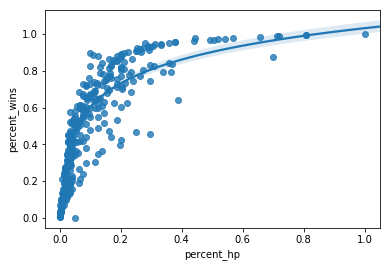

In [5]:
plot_correl('creatures_100.csv','hp',logx=True,subtitle='creatures from SRD')

### Correlation between cr and wins: creatures from SRD

r=0.750009

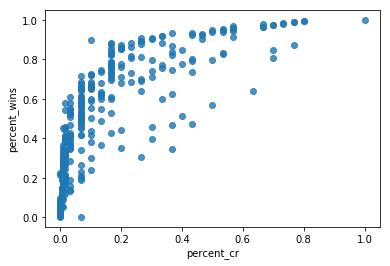

In [6]:
plot_correl('creatures_100.csv','cr',logx=True,subtitle='creatures from SRD')

In [7]:
creatures = pandas.read_csv('creatures.csv')
creatures_avg = creatures.groupby('cr').mean().apply(np.round).astype(int).reset_index()
creatures_avg['name'] = creatures_avg['cr']
run_matches(creatures_avg,100,'creatures_avg')

FloatProgress(value=0.0, description='Contest: ', max=378.0)

Performing 378 matches of 100 rounds each


### Correlation between hp and wins: averaged creatures from SRD

r=0.856207

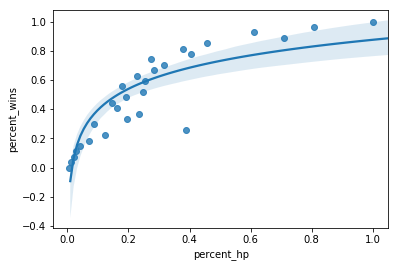

In [8]:
plot_correl('creatures_avg_100.csv','hp',logx=True,subtitle='averaged creatures from SRD')

### Correlation between cr and wins: averaged creatures from SRD

r=0.896555

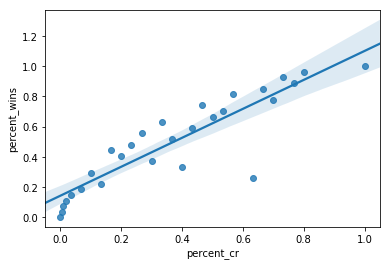

In [9]:
plot_correl('creatures_avg_100.csv','cr',subtitle='averaged creatures from SRD')

In [10]:
generics = pandas.read_csv('generics.csv')
run_matches(generics,100,'generics')

FloatProgress(value=0.0, description='Contest: ', max=528.0)

Performing 528 matches of 100 rounds each


### Correlation between hp and wins: generic creatures for each cr

r=0.966075

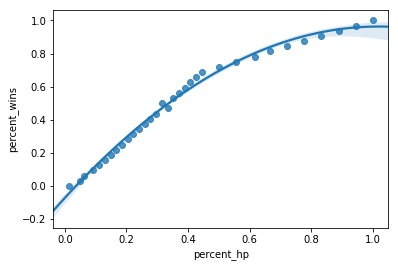

In [11]:
plot_correl('generics_100.csv','hp',order=2,subtitle='generic creatures for each cr')

### Correlation between cr and wins: generic creatures for each cr

r=0.998846

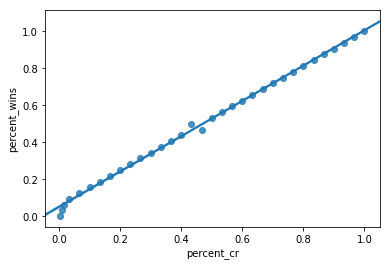

In [12]:
plot_correl('generics_100.csv','cr',subtitle='generic creatures for each cr')

In [13]:
randoms = create_randoms(33)
run_matches(randoms,100,'randoms')

FloatProgress(value=0.0, description='Contest: ', max=528.0)

Performing 528 matches of 100 rounds each


### Correlation between hp and wins: randomly-generated creatures

r=0.710729

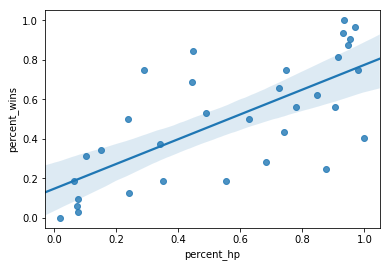

In [14]:
plot_correl('randoms_100.csv','hp',subtitle='randomly-generated creatures')

### Correlation between ac and wins: randomly-generated creatures

r=-0.164126

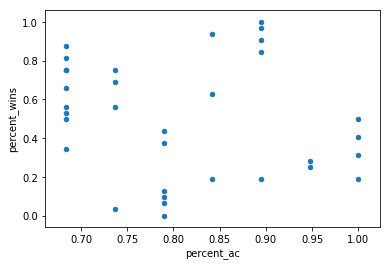

In [15]:
plot_correl('randoms_100.csv','ac',subtitle='randomly-generated creatures')

### Correlation between init and wins: randomly-generated creatures

r=-0.031805

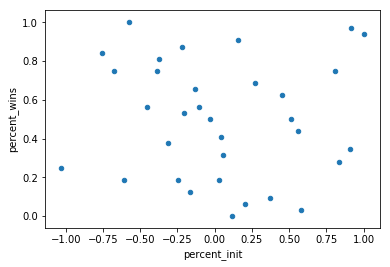

In [16]:
plot_correl('randoms_100.csv','init',subtitle='randomly-generated creatures')

### Correlation between hit_mod and wins: randomly-generated creatures

r=0.522340

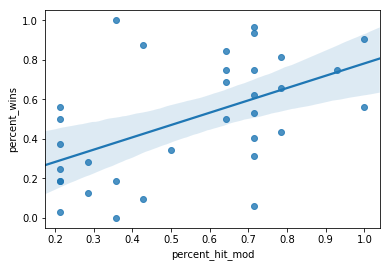

In [17]:
plot_correl('randoms_100.csv','hit_mod',subtitle='randomly-generated creatures')

### Correlation between dam_max and wins: randomly-generated creatures

r=0.753277

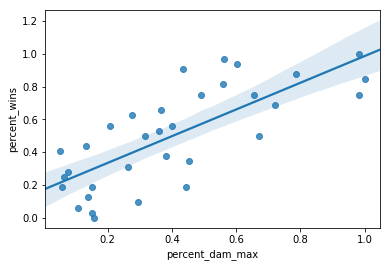

In [18]:
randoms = pandas.read_csv('randoms_100.csv')
randoms['dam_max'] = randoms['dam_avg'] * randoms['att_num']
plot_correl_df(randoms,'dam_max',subtitle='randomly-generated creatures')

In [19]:
fighters = pandas.read_csv('fighters.csv')
run_matches(fighters,100,'fighters')

FloatProgress(value=0.0, description='Contest: ', max=190.0)

Performing 190 matches of 100 rounds each


### Correlation between hp and wins: generic human fighters

r=0.994432

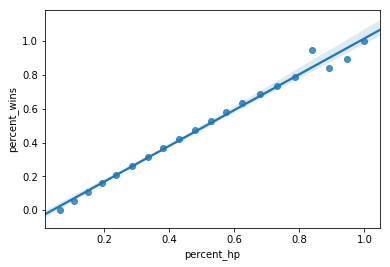

In [20]:
plot_correl('fighters_100.csv','hp',subtitle='generic human fighters')

### Correlation between dam_max and wins: generic human fighters

r=0.967958

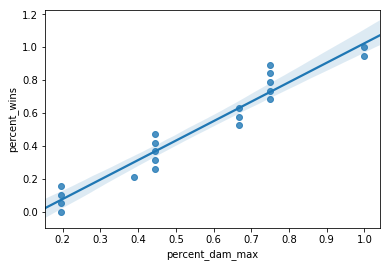

In [21]:
fighters = pandas.read_csv('fighters_100.csv')
fighters['dam_max'] = fighters['dam_avg'] * fighters['att_num']
plot_correl_df(fighters,'dam_max',subtitle='generic human fighters')

In [22]:
fighters = pandas.read_csv('fighters.csv')
fighters['type'] = 'fighter'
generics = pandas.read_csv('generics.csv')
generics['type'] = 'monster'
mixed = generics.append(fighters)
mixed = mixed.reset_index(drop=True)
run_matches(mixed,100,'mixed')

FloatProgress(value=0.0, description='Contest: ', max=1378.0)

Performing 1378 matches of 100 rounds each


### Correlation between hp and wins: generic human fighters and SRD creatures

r=0.904248

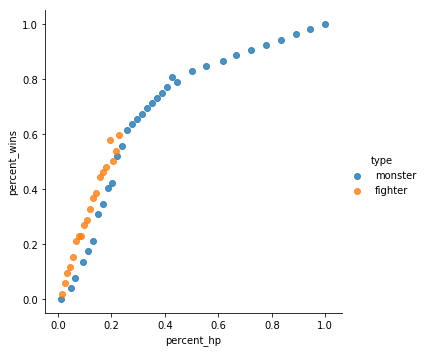

In [23]:
plot_correl('mixed_100.csv','hp',logx=True,subtitle='generic human fighters and SRD creatures')

### Correlation between dam_max and wins: generic human fighters and SRD creatures

r=0.874667

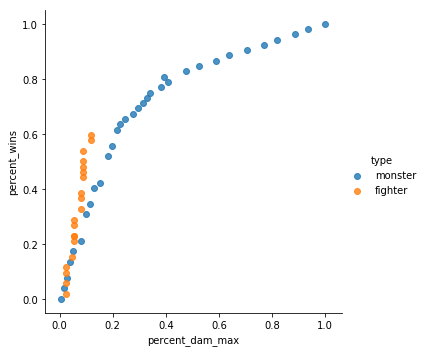

In [24]:
mixed = pandas.read_csv('mixed_100.csv')
mixed['dam_max'] = mixed['dam_avg'] * mixed['att_num']
plot_correl_df(mixed,'dam_max',logx=True,subtitle='generic human fighters and SRD creatures')

### Correlation between cr and wins: generic human fighters and SRD creatures

r=0.934027

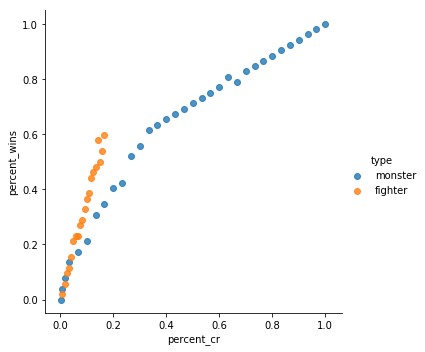

In [25]:
plot_correl('mixed_100.csv','cr',logx=True,subtitle='generic human fighters and SRD creatures')

In [26]:
party = pandas.read_csv('party.csv')
party['type'] = 'party'
generics = pandas.read_csv('generics.csv')
generics['type'] = 'monster'
mixed = generics.append(party)
mixed = mixed.reset_index(drop=True)
run_matches(mixed,100,'mixed_party')

FloatProgress(value=0.0, description='Contest: ', max=1378.0)

Performing 1378 matches of 100 rounds each


### Correlation between hp and wins: party of fighters and SRD creatures

r=0.965754

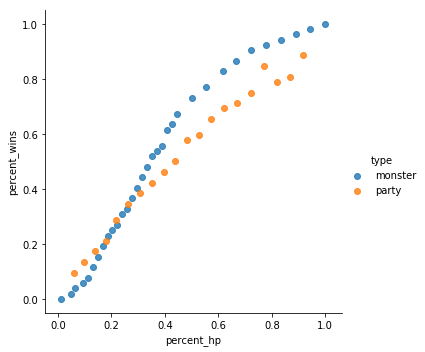

In [27]:
mixed = pandas.read_csv('mixed_party_100.csv')
plot_correl_df(mixed,'hp',logx=True,subtitle='party of fighters and SRD creatures')

### Correlation between ac and wins: party of fighters and SRD creatures

r=0.792505

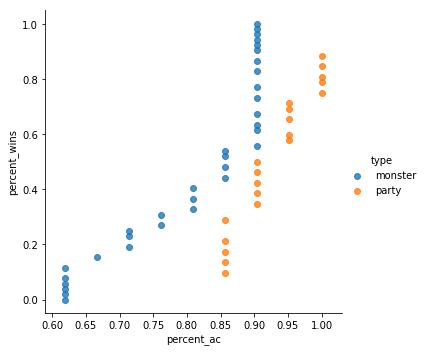

In [28]:
mixed = pandas.read_csv('mixed_party_100.csv')
plot_correl_df(mixed,'ac',logx=True,subtitle='party of fighters and SRD creatures')

### Correlation between dam_max and wins: party of fighters and SRD creatures

r=0.915375

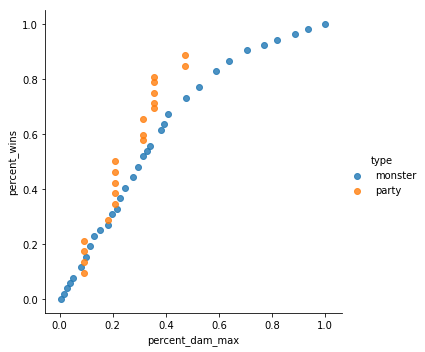

In [29]:
mixed['dam_max'] = mixed['dam_avg'] * mixed['att_num']
plot_correl_df(mixed,'dam_max',logx=True,subtitle='party of fighters and SRD creatures')

### Correlation between cr and wins: party of fighters and SRD creatures

r=0.961015

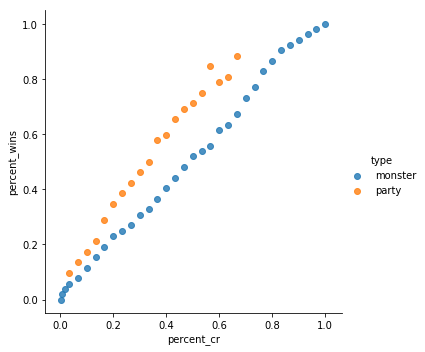

In [30]:
plot_correl_df(mixed,'cr',logx=True,subtitle='party of fighters and SRD creatures')

In [31]:
party = pandas.read_csv('party.csv')
party['type'] = 'party'
randoms = pandas.read_csv('randoms_100.csv').drop('pair_wins',1).drop('total_wins',1).drop('name',1)
randoms['type'] = 'monster'
mixed = party.append(randoms).drop('name',1).drop('cr',1)
mixed = mixed.reset_index(drop=True)
run_matches(mixed,100,'mixed_randoms')

FloatProgress(value=0.0, description='Contest: ', max=1378.0)

Performing 1378 matches of 100 rounds each


### Correlation between hp and wins: party of fighters and randomly-generated creatures

r=0.789706

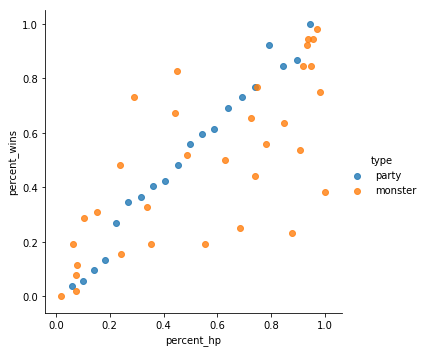

In [32]:
mixed = pandas.read_csv('mixed_randoms_100.csv')
plot_correl_df(mixed,'hp',logx=True,subtitle='party of fighters and randomly-generated creatures')

### Correlation between dam_max and wins: party of fighters and SRD creatures

r=0.703698

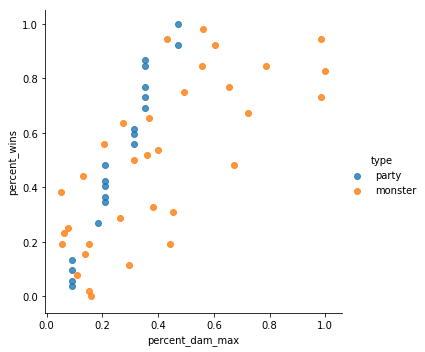

In [33]:
mixed['dam_max'] = mixed['dam_avg'] * mixed['att_num']
plot_correl_df(mixed,'dam_max',logx=True,subtitle='party of fighters and SRD creatures')